<a href="https://colab.research.google.com/github/Jaime44/WorkSpace/blob/main/models/neural%20network/00_NN_Recommender_system_movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys

# Comprueba si el código se está ejecutando en Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

path_absolute = ''
if IN_COLAB:
    print("El código se está ejecutando en Google Colab.")
    from google.colab import drive
    import tensorflow as tf
    print("Versión de TensorFlow:", tf.__version__)
    print("Dispositivos disponibles:", tf.config.list_physical_devices())

    drive.mount('/content/drive')
    path_absolute = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/Models/neural network'

    path_workspace = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/'

    # Cambia al directorio de tu carpeta en Google Drive
    os.chdir(path_absolute)

    # Lista los archivos y carpetas en el directorio actual
    contenido_carpeta = os.listdir(path_absolute)
    print("Contenido de la carpeta en Google Drive:")
    print(contenido_carpeta)

    # Verificar la GPU
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU no encontrada')
    print(f'Encontrada GPU: {device_name}')

    # Habilitar la GPU para TensorFlow
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print('Memoria de la GPU configurada dinámicamente')
    else:
        print('No se encontraron dispositivos GPU configurables')
else:
    print("El código se está ejecutando en un entorno local.")
    path_workspace ='C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/UNIR/TFM/WorkSpace/'
    path_absolute = os.getcwd().replace("\\", "/")
    path_absolute = 'C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/UNIR/TFM/WorkSpace/Models/neural network'

datasets_path = "/datasets/"
path_absolute = path_absolute+datasets_path


sys.path.append(path_workspace)

El código se está ejecutando en un entorno local.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import Utils.utils as util
import matplotlib.pyplot as plt


from keras import backend as K
from keras.models import Model
from IPython.display import SVG
from wordcloud import WordCloud
from keras.callbacks import EarlyStopping
# from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.layers import Dense,Dropout,Flatten,Embedding,BatchNormalization,Concatenate,Add,Concatenate,Dot,Input,dot,concatenate

In [3]:
               # 1  2  3  4  5  6  7  8
archiqture = [0, 1, 0, 1, 0, 1, 1, 0, 1]

In [4]:
# dataFrame_onehot_encode = pd.read_csv(path_absolute+'data_moviesRating_tgGen_tgUsrs_onehot_encode.csv', sep=',')

# dataFrame_onehot_encode.head()

In [5]:
dataFrame_without_ohe = pd.read_csv(path_absolute+'data_moviesRating_tgGen_tgUsrs.csv')
print(dataFrame_without_ohe.shape)
dataFrame_without_ohe.head()

C:\Users\jaime\AppData\Local\Temp\ipykernel_12408\4218327248.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  dataFrame_without_ohe = pd.read_csv(path_absolute+'data_moviesRating_tgGen_tgUsrs.csv')


(25000095, 8)


userId  movieId tag_by_user  \
0       1      296         NaN   
1       3      296         NaN   
2       4      296         NaN   
3       5      296         NaN   
4       7      296         NaN   

                                          tag_genome                title  \
0  masterpiece, hit men, gratuitous violence, dar...  Pulp Fiction (1994)   
1  masterpiece, hit men, gratuitous violence, dar...  Pulp Fiction (1994)   
2  masterpiece, hit men, gratuitous violence, dar...  Pulp Fiction (1994)   
3  masterpiece, hit men, gratuitous violence, dar...  Pulp Fiction (1994)   
4  masterpiece, hit men, gratuitous violence, dar...  Pulp Fiction (1994)   

                        genres   timestamp  rating  
0  Comedy|Crime|Drama|Thriller  1147880044     5.0  
1  Comedy|Crime|Drama|Thriller  1439474476     5.0  
2  Comedy|Crime|Drama|Thriller  1573938898     4.0  
3  Comedy|Crime|Drama|Thriller   830786155     4.0  
4  Comedy|Crime|Drama|Thriller   835444730     4.0

In [85]:
# Filtrar usuarios con al menos x calificaciones
min_n_ratings=500
df_aux = dataFrame_without_ohe.copy()
df_filtered_by_ratings_counts = df_aux.groupby('userId').filter(lambda x: len(x) >= min_n_ratings)
print(df_filtered_by_ratings_counts.shape)
# print(df_filtered['userId'].value_counts().sort_values(ascending=False))
# print(df_filtered['userId'].value_counts().sort_values(ascending=True))
df_filtered_by_ratings_counts.head()


(8960061, 8)


userId  movieId tag_by_user  \
1        3      296         NaN   
7       12      296         NaN   
34      72      296         NaN   
39      80      296         NaN   
58     120      296         NaN   

                                           tag_genome                title  \
1   masterpiece, hit men, gratuitous violence, dar...  Pulp Fiction (1994)   
7   masterpiece, hit men, gratuitous violence, dar...  Pulp Fiction (1994)   
34  masterpiece, hit men, gratuitous violence, dar...  Pulp Fiction (1994)   
39  masterpiece, hit men, gratuitous violence, dar...  Pulp Fiction (1994)   
58  masterpiece, hit men, gratuitous violence, dar...  Pulp Fiction (1994)   

                         genres   timestamp  rating  
1   Comedy|Crime|Drama|Thriller  1439474476     5.0  
7   Comedy|Crime|Drama|Thriller  1119354604     5.0  
34  Comedy|Crime|Drama|Thriller   980641292     5.0  
39  Comedy|Crime|Drama|Thriller   993326358     5.0  
58  Comedy|Crime|Drama|Thriller   963876169     5.0

In [7]:
dataFrame = df_filtered_by_ratings_counts.copy()
# dataFrame = dataFrame_onehot_encode.copy()

In [8]:
dataFrame = dataFrame.sample(n=250000, random_state=42)
df = dataFrame.copy()
print(df.shape)
df.head()

(250000, 8)


userId  movieId tag_by_user  \
13145068  107090    54272         NaN   
18620297   42780    46530         NaN   
18091014   74578      468         NaN   
8274091   116242    89745         NaN   
4812205   127739     1240         NaN   

                                                 tag_genome  \
13145068  animation, original, humor, based on a tv show...   
18620297  superheroes, big budget, super-hero, superhero...   
18091014  england, british comedy, whimsical, british, f...   
8274091   robert downey jr, superheroes, marvel, superhe...   
4812205     scifi, cyborgs, dystopic future, sci fi, future   

                                                      title  \
13145068                         Simpsons Movie, The (2007)   
18620297                            Superman Returns (2006)   
18091014  Englishman Who Went Up a Hill But Came Down a ...   
8274091                                Avengers, The (2012)   
4812205                              Terminator, The (1984)   

                                genres   timestamp  rating  
13145068              Animation|Comedy  1186455707     3.0  
18620297  Action|Adventure|Sci-Fi|IMAX  1152342173     4.0  
18091014                Comedy|Romance  1077814481     3.0  
8274091   Action|Adventure|Sci-Fi|IMAX  1557544000     4.0  
4812205         Action|Sci-Fi|Thriller  1343640825     4.5

In [9]:
# import pandas as pd

# # Supongamos que 'df' es tu DataFrame que contiene las columnas 'userId' y 'movieId'

# # Crear un diccionario para almacenar las ocurrencias de cada par de valores
# ocurrencias = {}

# # Iterar sobre el DataFrame para contar las ocurrencias de cada par de valores
# for index, row in df.iterrows():
#     userId = row['userId']
#     movieId = row['movieId']
#     par_valores = (userId, movieId)
#     ocurrencias[par_valores] = ocurrencias.get(par_valores, 0) + 1

# # Imprimir todas las ocurrencias encontradas
# for par_valores, frecuencia in ocurrencias.items():
#     print(f"El par de valores {par_valores} se repite {frecuencia} veces.")


In [10]:
df = df[~df.duplicated(subset=['userId', 'movieId'], keep='first')]

In [11]:
df.shape

(250000, 8)

## Explore dataset

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250000 entries, 13145068 to 19356361
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userId       250000 non-null  int64  
 1   movieId      250000 non-null  int64  
 2   tag_by_user  2316 non-null    object 
 3   tag_genome   246156 non-null  object 
 4   title        250000 non-null  object 
 5   genres       250000 non-null  object 
 6   timestamp    250000 non-null  int64  
 7   rating       250000 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 17.2+ MB


In [13]:
# Valores nulos
print(f"Valores nulos para la columna userId: {df['userId'].isnull().sum()}")
print(f"Valores nulos para la columna rating: {df['rating'].isnull().sum()}")
print(f"Valores nulos para la columna movieId: {df['movieId'].isnull().sum()}")

Valores nulos para la columna userId: 0
Valores nulos para la columna rating: 0
Valores nulos para la columna movieId: 0


In [14]:
# Se cuenta los valores unicos de rating
df['rating'].value_counts()

4.0    65225
3.0    48876
3.5    34636
5.0    31495
4.5    21850
2.0    17305
2.5    14197
1.0     7838
1.5     4324
0.5     4254
Name: rating, dtype: int64

In [15]:
# Se cuenta los valores unicos de usuarios
df['userId'].value_counts()

72315     440
80974     117
137293     94
33844      91
109731     89
         ... 
161234      1
68672       1
41159       1
104219      1
26435       1
Name: userId, Length: 57238, dtype: int64

In [16]:
# Se cuenta los valores unicos de peliculas
df['movieId'].value_counts()

356       608
2571      565
318       557
296       548
593       516
         ... 
7092        1
4136        1
820         1
114068      1
172569      1
Name: movieId, Length: 15144, dtype: int64

In [17]:
rango_valores = df['rating'].describe()['min'], df['rating'].describe()['max']
print("Rango de valores cd rating:", rango_valores)

Rango de valores cd rating: (0.5, 5.0)


In [18]:
#promedio de calificaciones agrupado por titulos
df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Captain Kidd (1945)                                                     5.0
Bad Chicken (2013)                                                      5.0
Mrs. 'Arris Goes to Paris (1992)                                        5.0
Holiday (Jour de fête) (1949)                                           5.0
Norman: The Moderate Rise and Tragic Fall of a New York Fixer (2017)    5.0
Straight-Jacket (2004)                                                  5.0
Last Year's Snow Was Falling (1983)                                     5.0
Unbelievable Truth, The (1989)                                          5.0
Story of O, The (Histoire d'O) (1975)                                   5.0
Adulthood (2008)                                                        5.0
Name: rating, dtype: float64

In [19]:
# Cuantos generos distintos hay y cuantqas peliculas clasificadas con ese genero entre otros.
if 'genres' in df.columns:
    genres = {}
    def find_genres():
        for genre in df['genres']:
            words = genre.split('|')
            for word in words:
                genres[word] = genres.get(word, 0) + 1
    find_genres()
    # genres['None'] = genres.pop('(no genres listed)')
    genres



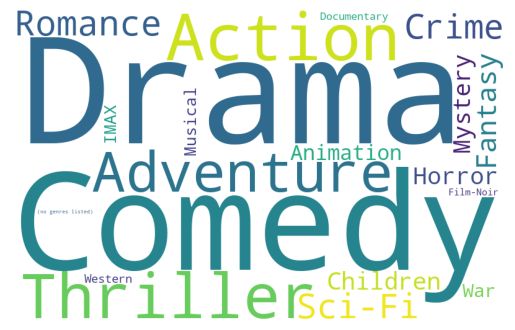

In [20]:
# Nube de palabras para los generos
if 'genres' in df.columns:
    wordcloud = WordCloud(width=800, height=500, background_color = 'white',
                        min_font_size=6, contour_color='black', contour_width=2).generate_from_frequencies(genres)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [21]:
#Peliculas más puntuadas
df_n_ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)
df_n_ratings.sort_values('total ratings', ascending=False).head(10)

mean ratings  \
title                                                              
Forrest Gump (1994)                                     4.059211   
Matrix, The (1999)                                      4.222124   
Shawshank Redemption, The (1994)                        4.345601   
Pulp Fiction (1994)                                     4.250000   
Silence of the Lambs, The (1991)                        4.096899   
Star Wars: Episode VI - Return of the Jedi (1983)       3.911133   
Star Wars: Episode IV - A New Hope (1977)               4.043393   
Jurassic Park (1993)                                    3.652000   
Star Wars: Episode V - The Empire Strikes Back ...      4.107214   
Back to the Future (1985)                               3.946653   

                                                    total ratings  
title                                                              
Forrest Gump (1994)                                           608  
Matrix, The (1999)                                            565  
Shawshank Redemption, The (1994)                              557  
Pulp Fiction (1994)                                           548  
Silence of the Lambs, The (1991)                              516  
Star Wars: Episode VI - Return of the Jedi (1983)             512  
Star Wars: Episode IV - A New Hope (1977)                     507  
Jurassic Park (1993)                                          500  
Star Wars: Episode V - The Empire Strikes Back ...            499  
Back to the Future (1985)                                     478

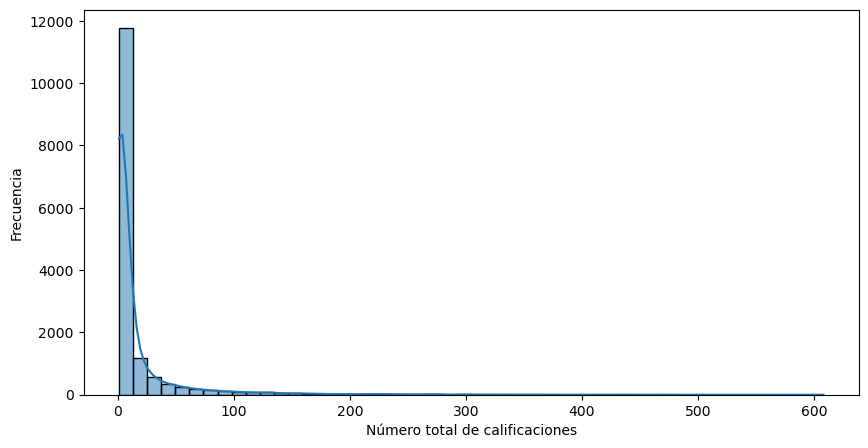

In [22]:
# histograma de la distribución de frecuencia del número total de calificaciones en el DataFrame
plt.figure(figsize=(10,5))
sns.histplot(df_n_ratings['total ratings'], bins=50, kde=True)  # kde=True incluye la estimación de densidad kernel
plt.xlabel('Número total de calificaciones')
plt.ylabel('Frecuencia')
plt.show()

In [23]:
# Calificaciones promedio más altas en función de la columna 'mean ratings'.
df_n_ratings.sort_values('mean ratings', ascending=False).head(10)

mean ratings  \
title                                                              
Captain Kidd (1945)                                          5.0   
Bad Chicken (2013)                                           5.0   
Mrs. 'Arris Goes to Paris (1992)                             5.0   
Holiday (Jour de fête) (1949)                                5.0   
Norman: The Moderate Rise and Tragic Fall of a ...           5.0   
Straight-Jacket (2004)                                       5.0   
Last Year's Snow Was Falling (1983)                          5.0   
Unbelievable Truth, The (1989)                               5.0   
Story of O, The (Histoire d'O) (1975)                        5.0   
Adulthood (2008)                                             5.0   

                                                    total ratings  
title                                                              
Captain Kidd (1945)                                             1  
Bad Chicken (2013)                                              1  
Mrs. 'Arris Goes to Paris (1992)                                1  
Holiday (Jour de fête) (1949)                                   1  
Norman: The Moderate Rise and Tragic Fall of a ...              2  
Straight-Jacket (2004)                                          1  
Last Year's Snow Was Falling (1983)                             1  
Unbelievable Truth, The (1989)                                  2  
Story of O, The (Histoire d'O) (1975)                           1  
Adulthood (2008)                                                1

In [24]:
print('Nº total de usuarios que han valorado con 5,0 : ', len(df_n_ratings.loc[df_n_ratings['mean ratings'] == 5]), '\n')
print('Nº total de usuarios individuales que han valorado con 5,0 : ', len(df_n_ratings.loc[(df_n_ratings['mean ratings'] == 5)
                                                                           & (df_n_ratings['total ratings'] == 1)]))

Nº total de usuarios que han valorado con 5,0 :  380 

Nº total de usuarios individuales que han valorado con 5,0 :  356


In [70]:
plt.figure(figsize=(10,5))
sns.histplot(df_n_ratings['mean ratings'], bins=10, kde=True)
plt.xlabel('Media de calificaciones')
plt.ylabel('Frecuencia')
plt.show()

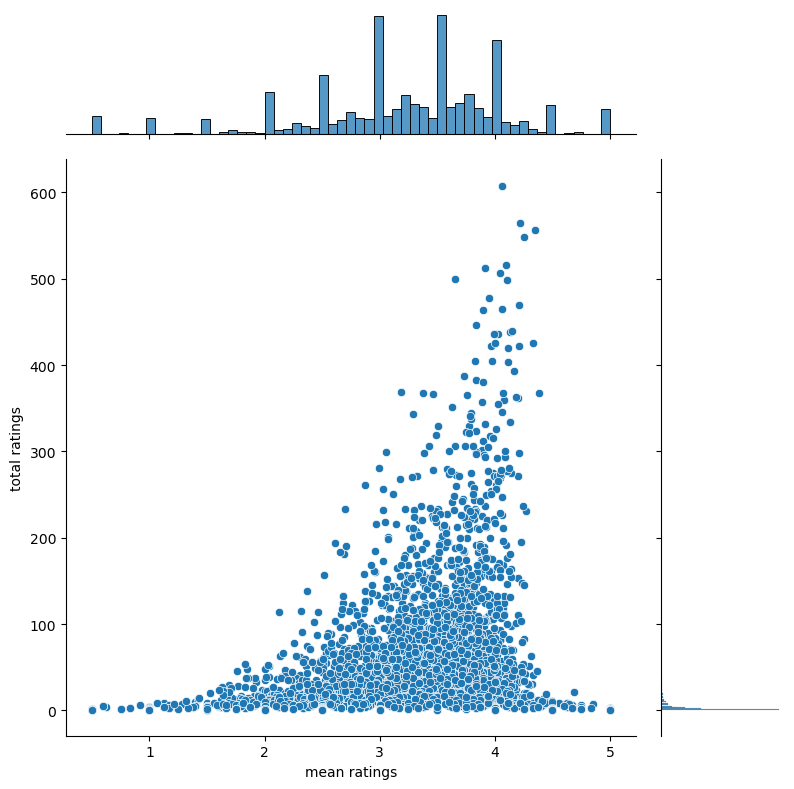

In [73]:
# Mean Ratings vs Total Number of Ratings
sns.jointplot(x='mean ratings', y='total ratings', data=df_n_ratings, height=8, ratio=4)


## MODELS

In [27]:
df.head(3)

userId  movieId tag_by_user  \
13145068  107090    54272         NaN   
18620297   42780    46530         NaN   
18091014   74578      468         NaN   

                                                 tag_genome  \
13145068  animation, original, humor, based on a tv show...   
18620297  superheroes, big budget, super-hero, superhero...   
18091014  england, british comedy, whimsical, british, f...   

                                                      title  \
13145068                         Simpsons Movie, The (2007)   
18620297                            Superman Returns (2006)   
18091014  Englishman Who Went Up a Hill But Came Down a ...   

                                genres   timestamp  rating  
13145068              Animation|Comedy  1186455707     3.0  
18620297  Action|Adventure|Sci-Fi|IMAX  1152342173     4.0  
18091014                Comedy|Romance  1077814481     3.0

In [28]:
df_aux = df.copy()
if 'genres' not in df.columns:
    columnas_deseadas = [col for col in df.columns if col not in ['tag_by_user', 'tag_genome', 'title', 'timestamp']]
    df_aux = df.loc[:, columnas_deseadas]
    print(df_aux.head())

In [29]:

# La asignación de índices únicos y la posterior división del DataFrame en conjuntos de entrenamiento y
# prueba pueden ser necesarias por varias razones en el contexto de modelos de recomendación y
# aprendizaje automático en general:

# Índices numéricos: Algunos algoritmos y modelos de aprendizaje automático requieren que las
# entradas sean números enteros. Al asignar índices únicos a los usuarios y películas,
# se asegura de que cada entidad esté representada por un identificador numérico único,
# lo que facilita el procesamiento por parte de los modelos.

# Consistencia en los datos de entrada: Al asignar índices únicos y transformar los datos originales,
# se crea una representación consistente y única para cada usuario y película en el conjunto de datos.
# Esto facilita el manejo y la interpretación de los datos durante el preprocesamiento y el entrenamiento
# del modelo.

# Reproducibilidad: La división aleatoria del DataFrame en conjuntos de entrenamiento y
# prueba utilizando np.random.rand() con una semilla (random_state) proporciona reproducibilidad.
# Esto significa que si vuelves a ejecutar el código con la misma semilla, obtendrás la misma
# división de datos, lo que es útil para comparar resultados y depurar el código.

# Evaluación del modelo: La división en conjuntos de entrenamiento y prueba es esencial para
# evaluar el rendimiento del modelo. El conjunto de entrenamiento se utiliza para entrenar el modelo,
# mientras que el conjunto de prueba se reserva para evaluar su rendimiento en datos no vistos.

# En resumen, estas operaciones son prácticas comunes en el preprocesamiento de datos para modelos
# de aprendizaje automático, especialmente cuando se trata de conjuntos de datos que contienen
# variables categóricas o identificadores que deben ser representados de manera numérica y
# cuando se busca garantizar la consistencia y la reproducibilidad en el procesamiento de datos.


# userId	movieId	timestamp_rt	tag_by_user	timestamp_tags	gen_tag	title	genres	tagId	relevance	rating
# df_aux = df_aux[['userId', 'movieId','rating']]

# Crear diccionarios de asignación de índices únicos
user_unique_ids = df_aux['userId'].unique()
movie_unique_ids = df_aux['movieId'].unique()

userid2idx = {user_id: idx for idx, user_id in enumerate(user_unique_ids)}
movieid2idx = {movie_id: idx for idx, movie_id in enumerate(movie_unique_ids)}

# Aplicar la asignación de índices únicos al DataFrame
df_aux['userId'] = df_aux['userId'].apply(lambda x: userid2idx[x])
df_aux['movieId'] = df_aux['movieId'].apply(lambda x: movieid2idx[x])

# Dividir dataset en entrenamiento y test
if 'genres' in df.columns:
    X = df_aux[['userId', 'movieId', 'genres']]  # UserId y movieId
    Y = df_aux['rating']                # rating
else:
    df_except_last = df.iloc[:, :-1]
    X = df_aux.iloc[:, :-1]
    Y = df_aux['rating']             


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Resetear los índices de x_train y x_test
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

n_genres = 19
print(f'Usuarios unicos: {len(user_unique_ids)} y peliculas unicas {len(movie_unique_ids)}')
print(x_train.shape , x_test.shape)

Usuarios unicos: 57238 y peliculas unicas 15144
(200000, 3) (50000, 3)


In [30]:
x_train

userId  movieId                                      genres
0        22325     4658             Action|Adventure|Fantasy|Sci-Fi
1         5287     7351                             Action|Thriller
2         3241     1770           Action|Adventure|Comedy|Drama|War
3        17704     4771                                 Crime|Drama
4         6406     1186                              Drama|Thriller
...        ...      ...                                         ...
199995   17950     2610  Action|Adventure|Animation|Children|Comedy
199996    5108      805                            Children|Fantasy
199997   47395     3175                   Action|Adventure|Thriller
199998    7376      535                        Comedy|Drama|Romance
199999   28355      950                          Action|Crime|Drama

[200000 rows x 3 columns]

In [31]:
y_train

0         2.0
1         3.0
2         3.0
3         3.0
4         3.0
         ... 
199995    2.0
199996    3.0
199997    4.0
199998    1.0
199999    5.0
Name: rating, Length: 200000, dtype: float64

### Definicicón de parametros

In [32]:
# Definición del número de factores latentes
n_latent_factors = 10
# learning_rate = 5e-4
lr = 1e-3
#Función de perdida
loss_function = 'mse'
#Bartch
batch_size = 128
#Epoch
epochs = 150
#Paciencia early stopping
pte = 3

In [33]:
es = EarlyStopping(monitor="val_loss",
                   mode="min",
                   verbose=1,
                   patience=pte)

In [34]:
# Deprecated
# def train_model(model):
#     # Entrenar el modelo y obtener el objeto history
#     history = model.fit(x=[x_train['userId'], x_train['movieId']], y=y_train,
#                         batch_size= batch_size, epochs=epochs, verbose= 1,
#                         validation_data=([x_test['userId'], x_test['movieId']], y_test),
#                         callbacks=[es])
#     return history

In [35]:
def train_model(model, x=None, y=None, x_test=None, y_test=None):
    # Definir los datos de entrada si no se proporcionan
    if x is None:
        x = [x_train['userId'], x_train['movieId']]
    if y is None:
        y = y_train
    if x_test is None:
        x_test = [x_test['userId'], x_test['movieId']] if x_test is not None else None  # Corrección aquí
    if y_test is None:
        y_test = y_test
    
    # Entrenar el modelo y obtener el objeto history
    history = model.fit(x=x, y=y,
                        batch_size=batch_size, epochs=epochs, verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=[es])
    return history


In [36]:
#Deprecated no tiene sentido mostrar el accuracy en modelos de regrsión
# def plot_loss(history):
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     accuracy = history.history['accuracy']
#     val_accuracy = history.history['val_accuracy']

#     fig, ax1 = plt.subplots(figsize=(10, 8))

#     color = 'tab:red'
#     ax1.set_xlabel('Epochs')
#     ax1.set_ylabel('Loss', color=color)
#     ax1.plot(loss, 'r--', label='Training Loss')
#     ax1.plot(val_loss, 'b-', label='Validation Loss')
#     ax1.tick_params(axis='y', labelcolor=color)

#     ax2 = ax1.twinx()
#     color = 'tab:green'
#     ax2.set_ylabel('Accuracy', color=color)
#     ax2.plot(accuracy, 'g-.', label='Training Accuracy')
#     ax2.plot(val_accuracy, 'y:', label='Validation Accuracy')
#     ax2.tick_params(axis='y', labelcolor=color)

#     # Añadir leyendas
#     ax1.legend(loc='upper left')
#     ax2.legend(loc='upper right')

#     fig.tight_layout()
#     plt.title('Model Loss and Accuracy')
#     plt.show()


def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, ax1 = plt.subplots(figsize=(10, 8))

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(loss, 'r--', label='Training Loss')
    ax1.plot(val_loss, 'b-', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    # Añadir leyendas
    ax1.legend(loc='upper left')

    fig.tight_layout()
    plt.title('Model Loss and Accuracy')
    plt.show()

### Arquitectura 1

In [37]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [38]:
# Obtención del número único de usuarios y películas en el conjunto de datos de calificaciones
n_users, n_movies = len(df['userId'].unique()), len(df['movieId'].unique())

# Definición de la entrada del usuario
user_input = Input(shape=(1,), name='User_Input')

# Creación de la capa de embedding para usuarios
user_embeddings = Embedding(input_dim=n_users, output_dim=n_latent_factors, input_length=1,
                            name='User_Embedding')(user_input)
user_vector = Flatten(name='User_Vector')(user_embeddings)

# Definición de la entrada de la película
movie_input = Input(shape=(1,), name='Movie_Input')

# Creación de la capa de embedding para películas
movie_embeddings = Embedding(input_dim=n_movies, output_dim=n_latent_factors, input_length=1,
                             name='Movie_Embedding')(movie_input)
movie_vector = Flatten(name='Movie_Vector')(movie_embeddings)

# Combinación de los vectores de usuario y película mediante el producto punto
merged_vectors = dot([user_vector, movie_vector], name='Dot_Product', axes=1)

# Creación del modelo utilizando Model API de Keras
model_a1 = Model([user_input, movie_input], merged_vectors)

model_a1.summary()
# Visualizar el modelo de Keras en formato DOT y luego lo convierte a formato SVG para mostrarlo
# SVG(model_to_dot( model_a1,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

#Compilar modelo SGD,Adagrad,Adadelta,RMSprop
model_a1.compile(loss=loss_function, optimizer = Adam(learning_rate=lr) )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Movie_Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User_Embedding (Embedding)     (None, 1, 10)        572380      ['User_Input[0][0]']             
                                                                                                  
 Movie_Embedding (Embedding)    (None, 1, 10)        151440      ['Movie_Input[0][0]']            
                                                                                              

### Arquitectura 2

In [39]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [40]:
# Obtener el número único de películas y usuarios en el DataFrame
n_movies = len(df['movieId'].unique())
n_users = len(df['userId'].unique())

# Definir la capa de entrada para el usuario con un solo valor entero (userId)
user_input = Input(shape=(1,), name='user_input', dtype='int64')

# Crear la capa de embedding para usuarios
user_embedding = Embedding(n_users, n_latent_factors, name='user_embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)  # Aplanar la salida de la capa de embedding
user_vec = Dropout(0.40)(user_vec)  # Aplicar Dropout para regularización

# Definir la capa de entrada para la película con un solo valor entero (movieId)
movie_input = Input(shape=(1,), name='movie_input', dtype='int64')

# Crear la capa de embedding para películas
movie_embedding = Embedding(n_movies, n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)  # Aplanar la salida de la capa de embedding
movie_vec = Dropout(0.40)(movie_vec)  # Aplicar Dropout para regularización

# Calcular la similitud entre los vectores de usuario y película mediante el producto punto
similarity = dot([user_vec, movie_vec], name='Similarity-Dot-Product', axes=1)

# Definir una capa de red neuronal para procesar la similitud calculada
nn_inp = Dense(96, activation='relu')(similarity)
nn_inp = Dropout(0.4)(nn_inp)  # Aplicar Dropout para regularización
# nn_inp = BatchNormalization()(nn_inp)  # Normalización por lotes (comentada, opcional)
nn_inp = Dense(1, activation='relu')(nn_inp)

# Crear el modelo utilizando Model API de Keras
model_a2 = Model([user_input, movie_input], nn_inp)
model_a2.summary()  # Mostrar resumen del modelo en términos de parámetros y capas

# Compilar el modelo con la función de pérdida y el optimizador especificados
model_a2.compile(loss=loss_function, optimizer= Adam(learning_rate=lr) )


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        572380      ['user_input[0][0]']             
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 10)        151440      ['movie_input[0][0]']            
                                                                                              

### Arquitectura 3

In [41]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [42]:
# Obtener el número único de películas y usuarios en el DataFrame
n_movies = len(df['movieId'].unique())
n_users = len(df['userId'].unique())

# Definir la capa de entrada para el usuario con un solo valor entero (userId)
user_input = Input(shape=(1,), name='User_Input')

# Crear la capa de embedding para usuarios
user_embeddings = Embedding(input_dim=n_users+1, output_dim=n_latent_factors, input_length=1, name='User_Embedding')(user_input)
user_vector = Flatten(name='User_Vector')(user_embeddings)  # Aplanar la salida de la capa de embedding

# Definir la capa de entrada para la película con un solo valor entero (movieId)
movie_input = Input(shape=(1,), name='Movie_input')

# Crear la capa de embedding para películas
movie_embeddings = Embedding(input_dim=n_movies+1, output_dim=n_latent_factors, input_length=1, name='Movie_Embedding')(movie_input)
movie_vector = Flatten(name='Movie_Vector')(movie_embeddings)  # Aplanar la salida de la capa de embedding

# Concatenar los vectores de usuario y película
merged_vectors = concatenate([user_vector, movie_vector], name='Concatenation')

# Capa densa con 100 unidades y función de activación ReLU
dense_layer_1 = Dense(100, activation='relu')(merged_vectors)

# Aplicar Dropout para regularización
dense_layer_3 = Dropout(0.5)(dense_layer_1)

# Capa densa de salida con 1 unidad
dense_layer_2 = Dense(1)(dense_layer_3)

# Crear el modelo utilizando Model API de Keras
model_a3 = Model([user_input, movie_input], dense_layer_2)

# Compilar el modelo con la función de pérdida, el optimizador y métricas especificados
model_a3.compile(loss=loss_function, optimizer=Adam(learning_rate=5e-4), metrics=['accuracy'])
model_a3.summary()  # Mostrar resumen del modelo en términos de parámetros y capas


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User_Embedding (Embedding)     (None, 1, 10)        572390      ['User_Input[0][0]']             
                                                                                                  
 Movie_Embedding (Embedding)    (None, 1, 10)        151450      ['Movie_input[0][0]']            
                                                                                              

### Arquitectura 4

In [43]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [44]:
# Definición de la entrada del usuario (user_input)
user_input = Input(shape=[1], name='user')  # Capa de entrada para la información del usuario.
# print(f"User Input Shape: {user_input.shape}")

# Creación de la capa de embedding para usuarios (user_embedding)
user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors, name='user_embedding')(user_input)
# La capa de embedding asigna a cada usuario un vector en el espacio de factores latentes.
# print(f"User Embedding Shape: {user_embedding.shape}")

# Aplanamiento de la capa de embedding para usuarios (user_vec)
user_vec = Flatten(name='flatten_users')(user_embedding)
# Se aplana el embedding para obtener un vector unidimensional que representa al usuario en el espacio de factores latentes.
# print(f"Flattened User Vector Shape: {user_vec.shape}")

# Definición de la entrada de la película (movie_input)
movie_input = Input(shape=[1], name='movie')  # Capa de entrada para la información de la película.
# print(f"Movie Input Shape: {movie_input.shape}")

# Creación de la capa de embedding para películas (movie_embedding)
movie_embedding = Embedding(input_dim=n_movies + 1, output_dim=n_latent_factors, name='movie_embedding')(movie_input)
# La capa de embedding asigna a cada película un vector en el espacio de factores latentes.
# print(f"Movie Embedding Shape: {movie_embedding.shape}")

# Aplanamiento de la capa de embedding para películas (movie_vec)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)
# Se aplana el embedding para obtener un vector unidimensional que representa la película en el espacio de factores latentes.
# print(f"Flattened Movie Vector Shape: {movie_vec.shape}")

# Cálculo del producto punto entre los vectores de película y usuario (product)
product = dot([movie_vec, user_vec], axes=1)
# El modelo calcula el producto punto entre los vectores de película y usuario para predecir las calificaciones.
# print(f"Product Shape: {product.shape}")

# Definición del modelo (model)
model_a4 = Model(inputs=[user_input, movie_input], outputs=product)

# Compilación del modelo con la función de pérdida y optimizador
model_a4.compile(loss=loss_function, optimizer = Adam(learning_rate=lr) )

model_a4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 10)        151450      ['movie[0][0]']                  
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        572390      ['user[0][0]']                   
                                                                                              

### Arquitectura 5

In [45]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [46]:
# Definir la entrada del usuario y su embedding
user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors, name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

# Definir la entrada de la película y su embedding
movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, output_dim=n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

# Concatenar los embeddings de usuario y película
concatenated = concatenate([user_vec, movie_vec], name='Concatenation')

# Añadir capas Dense con activación ReLU
dense_layer1 = Dense(128, activation='relu')(concatenated)
dense_layer2 = Dense(64, activation='relu')(dense_layer1)
dense_layer3 = Dense(32, activation='relu')(dense_layer2)

# Capa de salida con activación lineal
output = Dense(1, activation='linear')(dense_layer3)

# Crear el modelo con métrica R cuadrado
model_a5 = Model(inputs=[user_input, movie_input], outputs=output)

# Compilación del modelo con la función de pérdida y optimizador
model_a5.compile(loss=loss_function, optimizer = Adam(learning_rate=lr) )

model_a5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 movie (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        572390      ['user[0][0]']                   
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 10)        151450      ['movie[0][0]']                  
                                                                                              

### Arquitectura 6

In [47]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [48]:
user_input = Input(shape=(1,), name="user_id", dtype=tf.int32)
item_input = Input(shape=(1,), name="item_id", dtype=tf.int32)

user_embedding = Embedding(n_users,
                                  n_latent_factors,
                                  name="user_emb")(user_input)

user_bias = Embedding(n_users, 1, name="user_bias")(user_input)

item_embedding = Embedding(n_movies,
                                  n_latent_factors,
                                  name="item_emb")(item_input)
item_bias = Embedding(n_movies, 1, name="item_bias")(item_input)

user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

dot_user_item = Dot(name="dot", axes=1)([user_vector, item_vector])
output = Add(name="add")([dot_user_item, user_bias, item_bias])
output = Flatten(name="flat")(output)

model_a6 = Model([user_input, item_input], output, name="model_x")

model_a6.compile(loss=loss_function, optimizer = Adam(learning_rate=lr) )

model_a6.summary()

Model: "model_x"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 item_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user_emb (Embedding)           (None, 1, 10)        572380      ['user_id[0][0]']                
                                                                                                  
 item_emb (Embedding)           (None, 1, 10)        151440      ['item_id[0][0]']                
                                                                                            

In [49]:
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Definir las métricas personalizadas en TensorFlow/Keras
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / y_true)) * 100

def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def pearson_corr(y_true, y_pred):
    # Convertir y_pred a tipo float64
    y_pred = y_pred.astype(np.float64)
    # Calcular la correlación de Pearson
    return tfp.stats.correlation(y_true, y_pred, sample_axis=0, event_axis=1)


In [50]:
def calcular_metricas(model, x_test, y_test):
    # Obtener predicciones del modelo
    predictions = model.predict(x_test)
    
    # Aplanar predicciones
    predictions = predictions.ravel()
    
    # Calcular métricas
    rmse_val = rmse(y_test, predictions)
    mae_val = mae(y_test, predictions)
    mape_val = mape(y_test, predictions)
    mse_val = mse(y_test, predictions)
    r2_val = r2_score(y_test, predictions)
    # pearson_corr_val = pearson_corr(y_test, predictions)
    
    # Imprimir métricas
    print("RMSE:", rmse_val.numpy())
    print("MAE:", mae_val.numpy())
    print("MSE:", mse_val.numpy())
    print("R2 Score:", r2_val)
    print(f"MAPE: {(mape_val.numpy())/100} \nMAPE %: {mape_val.numpy()} %")
    # print("Pearson Correlation:", pearson_corr_val)

375/375 [==============================] - 1s 1ms/step:

Indica que se realizaron 375 iteraciones o pasos durante el proceso de evaluación, y cada iteración tardó aproximadamente 1 milisegundo.

1. Mean Squared Error (MSE): 3.0927204499125063:

El MSE es una medida del promedio de los cuadrados de las diferencias entre las predicciones del modelo y los valores reales. En este caso, un MSE de 3.09 indica que las predicciones tienden a desviarse, en promedio, al cuadrado de 3.09 unidades de la verdad.

2. Root Mean Squared Error (RMSE): 1.7586132178260534:

El RMSE es simplemente la raíz cuadrada del MSE. En este caso, un RMSE de 1.76 significa que, en promedio, las predicciones tienden a desviarse alrededor de 1.76 unidades de la verdad.

3. R Squared: -1.8672807452362834:

El R cuadrado (R2) es una medida de la proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes. Un valor negativo de R2 no es común y sugiere que el modelo no es apropiado para estos datos, ya que es peor que simplemente predecir la media de los datos observados.

4. Pearson Correlation: 0.3082110202566218:

La correlación de Pearson es una medida de la fuerza y dirección de la relación lineal entre dos variables. Un valor de 0.31 indica una correlación positiva débil. Sin embargo, la correlación por sí sola no proporciona una imagen completa y debe interpretarse junto con otras métricas.

En general, estas métricas sugieren que el modelo puede no estar funcionando tan bien en tus datos de prueba. El MSE y RMSE indican el error absoluto promedio, y un R2 negativo sugiere que el modelo no está explicando la varianza de los datos de manera efectiva. La correlación de Pearson, aunque positiva, es relativamente baja. Puedes considerar ajustar tu modelo o explorar otras métricas y técnicas para mejorar su rendimiento.

Basándome en los resultados proporcionados, puedo hacer algunas observaciones:

1. **Precision: 0.20:** La precisión es relativamente baja (20%). Esto podría indicar que, en promedio, solo el 20% de los elementos recomendados son relevantes para los usuarios. Una precisión más alta sería preferible.

2. **Recall: 1.0:** El recall es alto (100%). Esto sugiere que el modelo ha identificado todos los elementos relevantes para los usuarios en el conjunto de prueba. Aunque un recall del 100% es positivo, la baja precisión indica que también hay elementos irrelevantes en las recomendaciones.

3. **Mean Reciprocal Rank (MRR): 1.0:** El MRR es 1.0, lo que indica que, en promedio, el elemento relevante para cada usuario está en la posición 1 de las recomendaciones. Esto es una señal positiva, ya que un MRR de 1.0 sugiere que el modelo está dando la máxima prioridad a los elementos relevantes.

4. **Mean Average Precision (MAP): 1.0:** Un MAP de 1.0 indica que el modelo proporciona la máxima precisión para cada usuario, considerando todas las posiciones de las recomendaciones. Esto es un buen indicador de rendimiento.

5. **Coverage: 8.33e-05:** La cobertura es muy baja (0.0083%). Esto podría significar que el modelo tiene un conjunto limitado de elementos recomendados en comparación con el conjunto total de elementos posibles. Una mayor cobertura sería deseable para garantizar que el modelo pueda recomendar una amplia variedad de elementos.

En resumen, el modelo tiene un recall perfecto y una priorización efectiva de los elementos relevantes, pero la baja precisión y cobertura indican áreas donde podría mejorarse. Es crucial equilibrar la precisión y la cobertura para garantizar que el modelo proporcione recomendaciones relevantes y diversificadas.

In [51]:
# https://medium.com/decathlondigital/building-a-rnn-recommendation-engine-with-tensorflow-505644aa9ff3

# https://medium.com/@karina.condeixa/building-a-ranking-based-recommendations-system-e3adeb2c00f7

# https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54

# https://towardsdatascience.com/evaluation-metrics-for-recommendation-systems-an-overview-71290690ecba

# https://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html?source=post_page-----71290690ecba--------------------------------

### Arquitectura 7

In [52]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [53]:
hidden_units = [128, 64]

user_input = Input(shape=(1,), name="user_id", dtype=tf.int32)
item_input = Input(shape=(1,), name="item_id", dtype=tf.int32)
user_embedding = Embedding(n_users,
                                  n_latent_factors,
                                  name="user_emb")(user_input)
item_embedding = Embedding(n_movies,
                                  n_latent_factors,
                                  name="item_emb")(item_input)

concatenated = Concatenate(name="concat")([user_embedding, item_embedding])
out = Flatten(name="flat")(concatenated)

for n_hidden in hidden_units:
    out = Dense(n_hidden,
                       activation="relu")(out)
    out = Dropout(0.4)(out)
    out = BatchNormalization()(out)

out = Dense(1, activation="sigmoid", name="prediction")(out)

model_a7 = Model(inputs = [user_input, item_input],
                      outputs = out, name="model_y")

model_a7.compile(loss=loss_function, optimizer = Adam(learning_rate=lr) )

model_a7.summary()

Model: "model_y"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 item_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user_emb (Embedding)           (None, 1, 10)        572380      ['user_id[0][0]']                
                                                                                                  
 item_emb (Embedding)           (None, 1, 10)        151440      ['item_id[0][0]']                
                                                                                            

### Arquitectura 8

In [54]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [55]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Supongamos que tienes tus datos en las matrices 'usuarios', 'peliculas', 'generos' y 'calificaciones'
# 'usuarios', 'peliculas' y 'generos' son listas de IDs de usuarios, películas y géneros, respectivamente
# 'calificaciones' es una lista de calificaciones correspondientes a cada par usuario-película

# Convertir los datos de género a una lista de listas
generos_list = [generos.split('|') for generos in df_aux['genres']]

# Inicializar y ajustar el codificador one-hot
mlb = MultiLabelBinarizer()
generos_one_hot = mlb.fit_transform(generos_list)

#------------------------------------------------------------------------------
# # Asignar índices únicos a usuarios y películas
# user_unique_ids = df_aux['userId'].unique()
# movie_unique_ids = df_aux['movieId'].unique()

# userid2idx = {user_id: idx for idx, user_id in enumerate(user_unique_ids)}
# movieid2idx = {movie_id: idx for idx, movie_id in enumerate(movie_unique_ids)}

# # Aplicar la asignación de índices únicos al DataFrame
# df_aux['userId'] = df_aux['userId'].apply(lambda x: userid2idx[x])
# df_aux['movieId'] = df_aux['movieId'].apply(lambda x: movieid2idx[x])

# # Dividir dataset en entrenamiento y test
# x_train, x_test, y_train, y_test = train_test_split(df_aux[['userId', 'movieId', 'genres']], df_aux['rating'], test_size=0.2, random_state=42)

# # Resetear los índices de x_train y x_test
# x_train.reset_index(drop=True, inplace=True)
# x_test.reset_index(drop=True, inplace=True)
#------------------------------------------------------------------------------

# Definir las capas de entrada
input_usuario = Input(shape=[1])
input_pelicula = Input(shape=[1])
input_genero = Input(shape=[generos_one_hot.shape[1]])  # Número de géneros únicos

# Definir las capas de embedding para usuarios y películas
embedding_usuario = Embedding(input_dim=len(user_unique_ids), output_dim=50)(input_usuario)
embedding_pelicula = Embedding(input_dim=len(movie_unique_ids), output_dim=50)(input_pelicula)

# Aplanar las capas de embedding
flat_usuario = Flatten()(embedding_usuario)
flat_pelicula = Flatten()(embedding_pelicula)

# Concatenar las capas de embedding con los géneros codificados one-hot
concat = Concatenate()([flat_usuario, flat_pelicula, input_genero])

# Agregar capas densas
dense1 = Dense(128, activation='relu')(concat)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(1)(dense2)

# Compilar el modelo
modelo_a8 = Model(inputs=[input_usuario, input_pelicula, input_genero], outputs=output)
# Generar la codificación one-hot de los géneros solo para las filas relevantes
generos_one_hot_train = generos_one_hot[x_train.index]
generos_one_hot_test = generos_one_hot[x_test.index]

# Compilar el modelo
modelo_a8.compile(loss='mse', optimizer='adam', metrics=['mae'])
modelo_a8.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        2861900     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        757200      ['input_2[0][0]']                
                                                                                              

# A1

Epoch 1/150
1563/1563 [==============================] - 9s 6ms/step - loss: 13.2572 - val_loss: 13.2398
Epoch 2/150
1563/1563 [==============================] - 10s 6ms/step - loss: 12.9815 - val_loss: 12.7926
Epoch 3/150
1563/1563 [==============================] - 9s 6ms/step - loss: 11.3791 - val_loss: 11.0446
Epoch 4/150
1563/1563 [==============================] - 9s 6ms/step - loss: 8.4196 - val_loss: 8.5706
Epoch 5/150
1563/1563 [==============================] - 9s 6ms/step - loss: 5.5790 - val_loss: 6.5781
Epoch 6/150
1563/1563 [==============================] - 9s 6ms/step - loss: 3.7568 - val_loss: 5.3618
Epoch 7/150
1563/1563 [==============================] - 9s 6ms/step - loss: 2.6742 - val_loss: 4.6196
Epoch 8/150
1563/1563 [==============================] - 9s 6ms/step - loss: 1.9840 - val_loss: 4.1504
Epoch 9/150
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5210 - val_loss: 3.8456
Epoch 10/150
1563/1563 [==============================] - 8s 5ms/s

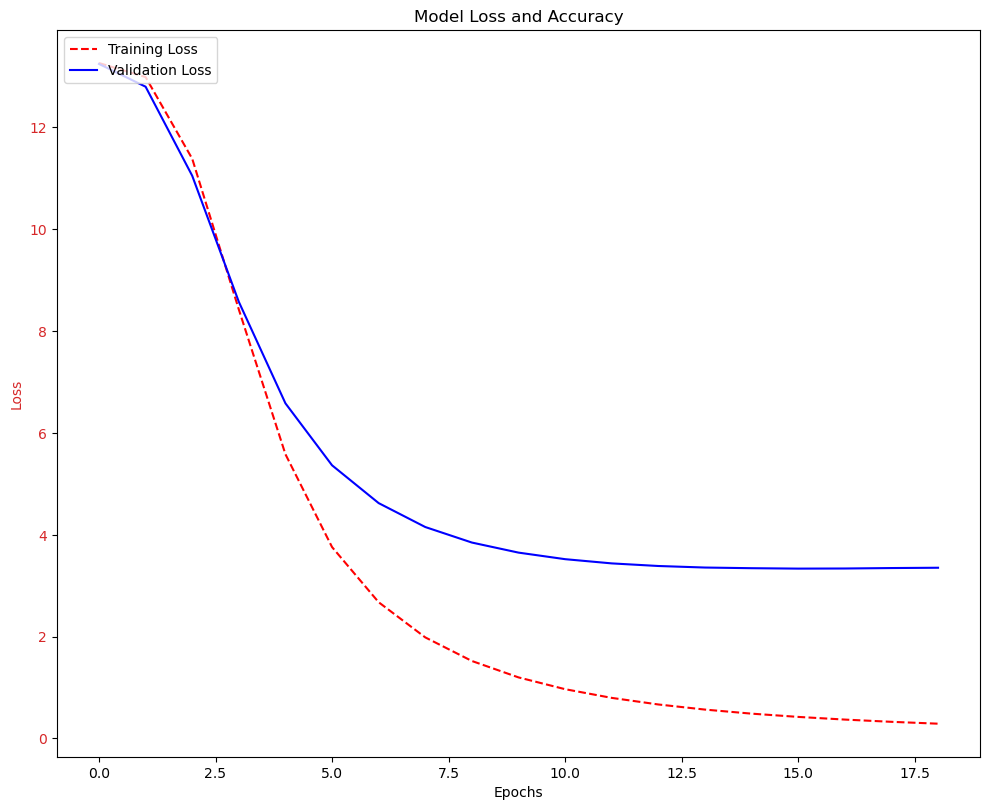

1563/1563 [==============================] - 3s 2ms/step
RMSE: 1.8306356592652826
MAE: 1.3999594393665744
MSE: 3.3512269169736357
R2 Score: -2.0108098202609326
MAPE: 0.46009273426281566 
MAPE %: 46.00927342628157 %


In [56]:
if archiqture[1] == 1:
    history_mda1 = train_model(model_a1, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
    plot_loss(history_mda1)
    # Llamar a la función para calcular métricas
    calcular_metricas(model_a1, [x_test['userId'], x_test['movieId']], y_test)

# A2

In [57]:
if archiqture[2] == 1:
    history_mda2 = train_model(model_a2, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
    plot_loss(history_mda2)
    calcular_metricas(model_a2, [x_test['userId'], x_test['movieId']], y_test)

Epoch 1/150
1563/1563 [==============================] - 14s 8ms/step - loss: 1.8483 - val_loss: 1.1195
Epoch 2/150
1563/1563 [==============================] - 12s 8ms/step - loss: 1.2344 - val_loss: 1.1165
Epoch 3/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1559 - val_loss: 1.1525
Epoch 4/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0392 - val_loss: 1.1600
Epoch 5/150
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9336 - val_loss: 1.1832
Epoch 5: early stopping


1563/1563 [==============================] - 3s 2ms/step
RMSE: 1.087750763522923
MAE: 0.860793178536892
MSE: 1.1832017235447023
R2 Score: -0.06301228083209343
MAPE: 0.4051669782135752 
MAPE %: 40.516697821357525 %


# A3

In [58]:
if archiqture[3] == 1:
    history_mda3 = train_model(model_a3, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
    plot_loss(history_mda3)
    calcular_metricas(model_a3, [x_test['userId'], x_test['movieId']], y_test)

Epoch 1/150
1563/1563 [==============================] - 11s 7ms/step - loss: 2.1995 - accuracy: 0.0297 - val_loss: 0.9086 - val_accuracy: 0.0306
Epoch 2/150
1563/1563 [==============================] - 10s 7ms/step - loss: 0.9495 - accuracy: 0.0315 - val_loss: 0.8788 - val_accuracy: 0.0306
Epoch 3/150
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8362 - accuracy: 0.0315 - val_loss: 0.9010 - val_accuracy: 0.0305
Epoch 4/150
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7707 - accuracy: 0.0315 - val_loss: 0.9000 - val_accuracy: 0.0305
Epoch 5/150
1563/1563 [==============================] - 10s 6ms/step - loss: 0.7177 - accuracy: 0.0315 - val_loss: 0.9106 - val_accuracy: 0.0305
Epoch 5: early stopping


1563/1563 [==============================] - 3s 2ms/step
RMSE: 0.9542370836813042
MAE: 0.7371462583398819
MSE: 0.9105684118726003
R2 Score: 0.18192698244342942
MAPE: 0.32435016435450315 
MAPE %: 32.435016435450315 %


# A4

Epoch 1/150
1563/1563 [==============================] - 10s 6ms/step - loss: 13.2582 - val_loss: 13.2460
Epoch 2/150
1563/1563 [==============================] - 8s 5ms/step - loss: 13.0710 - val_loss: 13.0390
Epoch 3/150
1563/1563 [==============================] - 9s 6ms/step - loss: 11.9505 - val_loss: 12.0029
Epoch 4/150
1563/1563 [==============================] - 9s 6ms/step - loss: 9.6067 - val_loss: 10.1770
Epoch 5/150
1563/1563 [==============================] - 10s 6ms/step - loss: 6.8539 - val_loss: 8.2434
Epoch 6/150
1563/1563 [==============================] - 10s 6ms/step - loss: 4.6665 - val_loss: 6.7962
Epoch 7/150
1563/1563 [==============================] - 10s 6ms/step - loss: 3.2664 - val_loss: 5.8687
Epoch 8/150
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3749 - val_loss: 5.2781
Epoch 9/150
1563/1563 [==============================] - 10s 6ms/step - loss: 1.7790 - val_loss: 4.8925
Epoch 10/150
1563/1563 [==============================] - 9s 

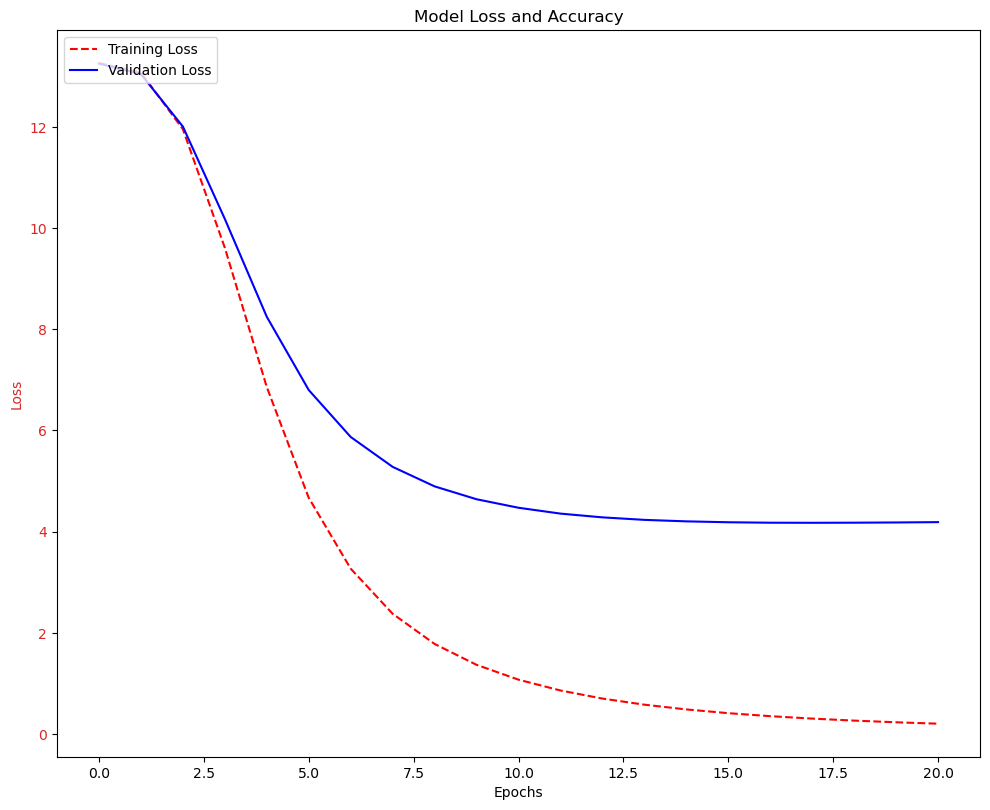

1563/1563 [==============================] - 3s 2ms/step
RMSE: 2.045962830045153
MAE: 1.6128318940400537
MSE: 4.185963901926372
R2 Score: -2.7607543551718403
MAPE: 0.5092663599293649 
MAPE %: 50.92663599293649 %


In [59]:
if archiqture[4] == 1:
    history_mda4 = train_model(model_a4, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
    plot_loss(history_mda4)
    calcular_metricas(model_a4, [x_test['userId'], x_test['movieId']], y_test)

# A5

Epoch 1/150
1563/1563 [==============================] - 12s 7ms/step - loss: 1.1882 - val_loss: 0.8689
Epoch 2/150
1563/1563 [==============================] - 12s 8ms/step - loss: 0.7343 - val_loss: 0.8657
Epoch 3/150
1563/1563 [==============================] - 12s 8ms/step - loss: 0.6403 - val_loss: 0.8907
Epoch 4/150
1563/1563 [==============================] - 12s 8ms/step - loss: 0.5585 - val_loss: 0.9335
Epoch 5/150
1563/1563 [==============================] - 12s 8ms/step - loss: 0.4757 - val_loss: 0.9417
Epoch 5: early stopping


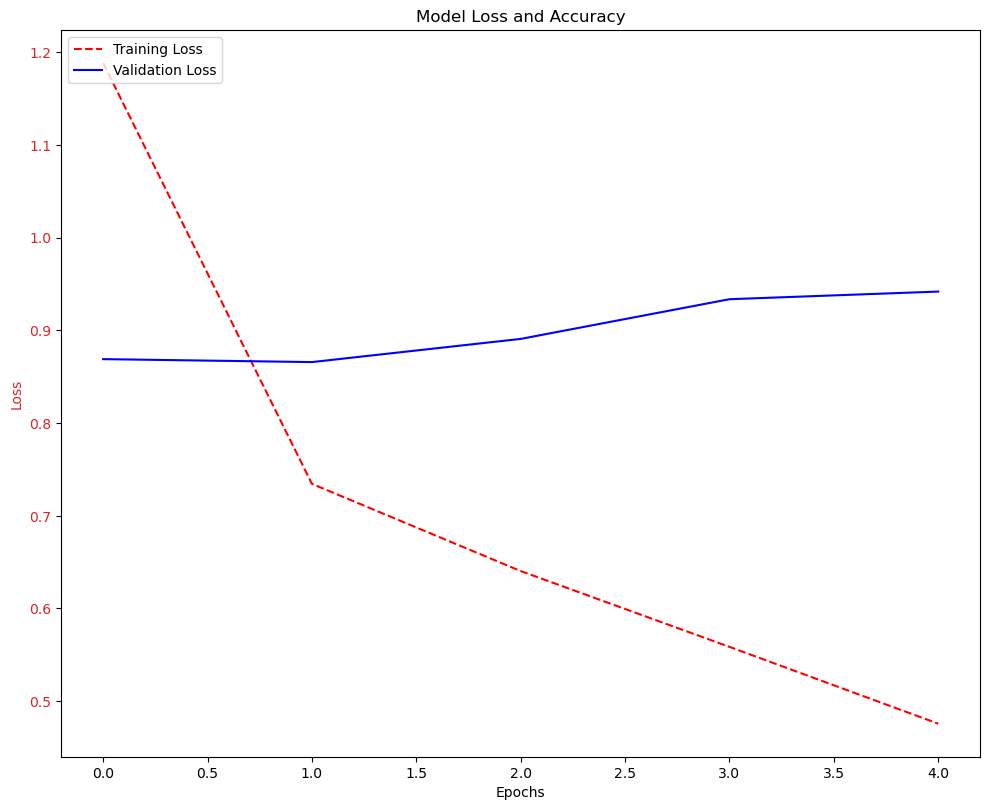

1563/1563 [==============================] - 4s 2ms/step
RMSE: 0.97043022924304
MAE: 0.7502121621418
MSE: 0.9417348298286992
R2 Score: 0.1539264442616345
MAPE: 0.3275869071067808 
MAPE %: 32.75869071067808 %


In [60]:
if archiqture[5] == 1:
    history_mda5 = train_model(model_a5, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
    plot_loss(history_mda5)
    calcular_metricas(model_a5, [x_test['userId'], x_test['movieId']], y_test)

# A6

Epoch 1/150
1563/1563 [==============================] - 11s 7ms/step - loss: 12.0197 - val_loss: 10.7873
Epoch 2/150
1563/1563 [==============================] - 12s 7ms/step - loss: 9.5258 - val_loss: 8.5947
Epoch 3/150
1563/1563 [==============================] - 12s 7ms/step - loss: 6.9850 - val_loss: 6.5143
Epoch 4/150
1563/1563 [==============================] - 11s 7ms/step - loss: 4.6082 - val_loss: 4.8112
Epoch 5/150
1563/1563 [==============================] - 11s 7ms/step - loss: 2.9497 - val_loss: 3.7379
Epoch 6/150
1563/1563 [==============================] - 10s 6ms/step - loss: 1.9961 - val_loss: 3.1473
Epoch 7/150
1563/1563 [==============================] - 12s 8ms/step - loss: 1.4308 - val_loss: 2.8158
Epoch 8/150
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0669 - val_loss: 2.6306
Epoch 9/150
1563/1563 [==============================] - 12s 8ms/step - loss: 0.8182 - val_loss: 2.5243
Epoch 10/150
1563/1563 [==============================] - 10s 

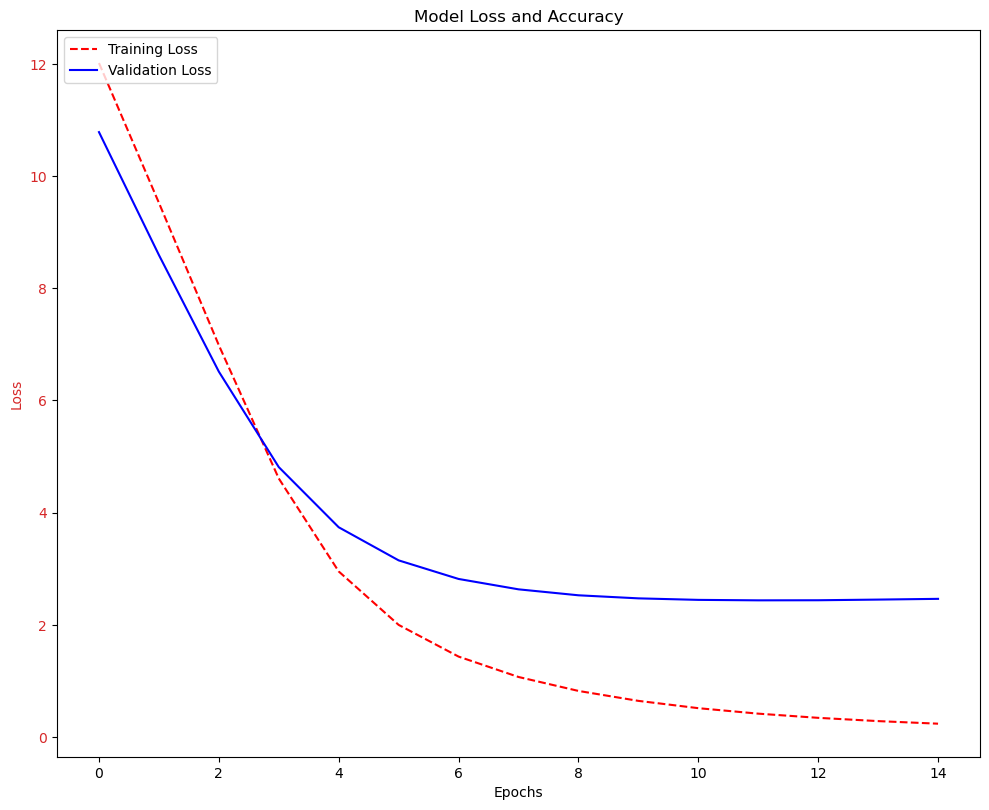

1563/1563 [==============================] - 3s 2ms/step
RMSE: 1.568724422838507
MAE: 1.269974398384327
MSE: 2.4608963148100074
R2 Score: -1.210918858924943
MAPE: 0.4166125393483922 
MAPE %: 41.66125393483922 %


In [61]:
if archiqture[6] == 1:
    history_mda6 = train_model(model_a6, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
    plot_loss(history_mda6)
    calcular_metricas(model_a6, [x_test['userId'], x_test['movieId']], y_test)

# A7

In [62]:
if archiqture[7] == 1:
    history_mda7 = train_model(model_a7, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
    plot_loss(history_mda7)
    calcular_metricas(model_a7, [x_test['userId'], x_test['movieId']], y_test)

Epoch 1/150
1563/1563 [==============================] - 14s 8ms/step - loss: 7.4974 - val_loss: 7.2836
Epoch 2/150
1563/1563 [==============================] - 13s 8ms/step - loss: 7.2901 - val_loss: 7.2823
Epoch 3/150
1563/1563 [==============================] - 14s 9ms/step - loss: 7.2896 - val_loss: 7.2822
Epoch 4/150
1563/1563 [==============================] - 14s 9ms/step - loss: 7.2895 - val_loss: 7.2819
Epoch 5/150
1563/1563 [==============================] - 14s 9ms/step - loss: 7.2894 - val_loss: 7.2819
Epoch 6/150
1563/1563 [==============================] - 15s 9ms/step - loss: 7.2894 - val_loss: 7.2819
Epoch 7/150
1563/1563 [==============================] - 15s 9ms/step - loss: 7.2894 - val_loss: 7.2819
Epoch 8/150
1563/1563 [==============================] - 15s 10ms/step - loss: 7.2894 - val_loss: 7.2819
Epoch 9/150
1563/1563 [==============================] - 14s 9ms/step - loss: 7.2894 - val_loss: 7.2819
Epoch 10/150
1563/1563 [==============================] - 14s 9

1563/1563 [==============================] - 4s 2ms/step
RMSE: 2.69850514174162
MAE: 2.500560000001192
MSE: 7.281930000005961
R2 Score: -5.542232709884594
MAPE: 0.6851839523812921 
MAPE %: 68.51839523812922 %


# A8

Epoch 1/150
1563/1563 [==============================] - 44s 28ms/step - loss: 1.1270 - mae: 0.8075 - val_loss: 0.8758 - val_mae: 0.7274
Epoch 2/150
1563/1563 [==============================] - 43s 27ms/step - loss: 0.6659 - mae: 0.6206 - val_loss: 0.9127 - val_mae: 0.7443
Epoch 3/150
1563/1563 [==============================] - 50s 32ms/step - loss: 0.3947 - mae: 0.4644 - val_loss: 0.9969 - val_mae: 0.7746
Epoch 4/150
1563/1563 [==============================] - 38s 24ms/step - loss: 0.2321 - mae: 0.3567 - val_loss: 1.0606 - val_mae: 0.7987
Epoch 4: early stopping


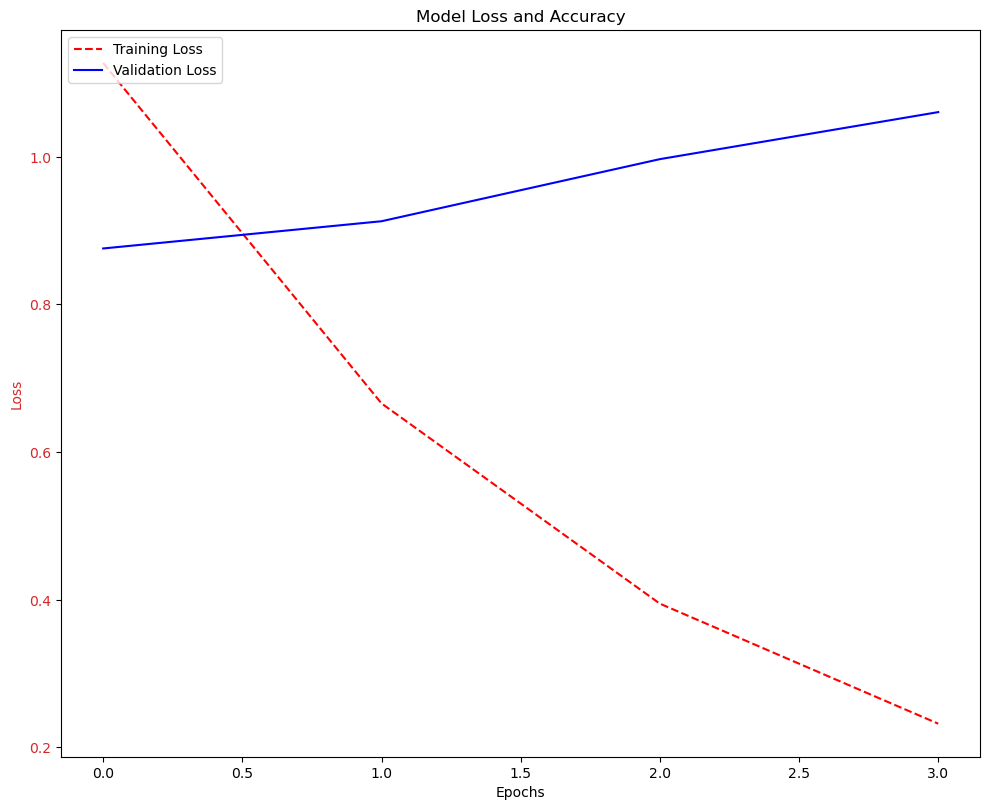

1563/1563 [==============================] - 4s 3ms/step
RMSE: 1.0298333498668046
MAE: 0.7986723094344139
MSE: 1.0605567284978843
R2 Score: 0.04717445514288443
MAPE: 0.34883089471919243 
MAPE %: 34.88308947191924 %


In [63]:
if archiqture[8] == 1:    
    # history_mda8 = modelo_a8.fit([x_train['userId'], x_train['movieId'], generos_one_hot_train], y_train, epochs=10, batch_size=128, validation_data=([x_test['userId'], x_test['movieId'], generos_one_hot_test], y_test))
    history_mda8 = train_model(modelo_a8, [x_train['userId'], x_train['movieId'], generos_one_hot_train], y_train, [x_test['userId'], x_test['movieId'], generos_one_hot_test], y_test)
    plot_loss(history_mda8)
    calcular_metricas(modelo_a8, [x_test['userId'], x_test['movieId'], generos_one_hot_test], y_test)

In [64]:
x_test

userId  movieId                              genres
0       24783     1271                               Drama
1       19694     1749                               Drama
2        3672     1088                       Horror|Sci-Fi
3       17212     1789                      Drama|Thriller
4        8981     1563              Adventure|Fantasy|IMAX
...       ...      ...                                 ...
49995    1311     7170          Animation|Children|Musical
49996   44712      437  Action|Horror|Sci-Fi|Thriller|IMAX
49997    6113     1833              Crime|Mystery|Thriller
49998    8820      732                    Action|Drama|War
49999   31496     4913                      Crime|Thriller

[50000 rows x 3 columns]

In [65]:
y_test

0        4.0
1        5.0
2        2.0
3        5.0
4        2.5
        ... 
49995    3.5
49996    4.0
49997    4.5
49998    4.0
49999    4.0
Name: rating, Length: 50000, dtype: float64

In [80]:
import random
# Encuentra los valores que se repiten al menos n veces
n = 10
valores_repetidos = x_test['userId'].value_counts()
valores_cumplen_criterio = valores_repetidos[valores_repetidos >= n]

if not valores_cumplen_criterio.empty:
    user = random.choice(valores_cumplen_criterio.index)
    print(f"Valor que se repite al menos {n} veces (seleccionado aleatoriamente):", user)
else:
    print(f"No hay ningún valor que se repita al menos {n} veces en la columna 'userId'.")


Valor que se repite al menos 10 veces (seleccionado aleatoriamente): 2495


In [81]:
x_test[(x_test['userId'] == user)]


userId  movieId                          genres
1838     2495     5484                Adventure|Comedy
7198     2495     5478              Action|Crime|Drama
8526     2495      213      Adventure|Children|Fantasy
14149    2495     2912                  Comedy|Romance
19174    2495     6657                           Drama
22943    2495    14861                         Western
24548    2495     7384        Adventure|Comedy|Romance
28287    2495      409  Action|Adventure|Drama|Fantasy
42382    2495     5848                          Comedy
43755    2495       15                     Crime|Drama
48049    2495     2689             Crime|Drama|Western

In [82]:
#Concatenar el dataframe de test con el objeto series de claificaciones
df_test_concat = pd.concat([x_test, y_test], axis=1)
#Obtenemos un dataframe para un único usuario
df_test_by_unq_user = df_test_concat.loc[df_test_concat['userId'] == user]
#Obtenemos un objeto Series con la columna rating a predecir. 
y_test_by_unq_user = df_test_by_unq_user['rating']
y_test_by_unq_user

1838     0.5
7198     1.0
8526     3.0
14149    5.0
19174    5.0
22943    4.0
24548    0.5
28287    5.0
42382    0.5
43755    5.0
48049    5.0
Name: rating, dtype: float64

In [ ]:
[[1.317654 ] 0.5
 [2.1229262] 1.0
 [2.5429711] 3.0
 [2.9641466] 5.0
 [2.4137244] 5.0
 [2.2499585] 4.0
 [1.890693 ] 0.5
 [3.2009585] 5.0
 [1.5319955] 0.5
 [2.8756042] 5.0
 [3.139177 ]] 5.0

In [83]:
lista_modelos = [model_a1, model_a2, model_a3, model_a4, model_a5, model_a6, model_a7, modelo_a8]
for i, modelo in enumerate(lista_modelos, start=1):
    if archiqture[i] == 1:  
        if i == 8:
            predicciones = modelo.predict([df_test_by_unq_user['userId'], df_test_by_unq_user['movieId'], generos_one_hot[df_test_by_unq_user.index]])
        else:
            predicciones = modelo.predict([df_test_by_unq_user['userId'], df_test_by_unq_user['movieId']])
        print(f"Predicciones del modelo {i}:")
        print(predicciones)

1/1 [==============================] - 0s 27ms/step
Predicciones del modelo 1:
[[0.5091641 ]
 [3.24836   ]
 [2.4743786 ]
 [1.8980492 ]
 [1.1468183 ]
 [0.01343113]
 [2.9870014 ]
 [3.181228  ]
 [2.185879  ]
 [3.905316  ]
 [4.932408  ]]
1/1 [==============================] - 0s 40ms/step


Predicciones del modelo 2:
[[3.888108 ]
 [3.7180636]
 [3.3087146]
 [2.931951 ]
 [3.883515 ]
 [3.444437 ]
 [4.2614045]
 [2.230474 ]
 [4.060895 ]
 [3.7799106]
 [3.054049 ]]
1/1 [==============================] - 0s 40ms/step
Predicciones del modelo 3:
[[1.317654 ]
 [2.1229262]
 [2.5429711]
 [2.9641466]
 [2.4137244]
 [2.2499585]
 [1.890693 ]
 [3.2009585]
 [1.5319955]
 [2.8756042]
 [3.139177 ]]
1/1 [==============================] - 0s 40ms/step
Predicciones del modelo 4:
[[2.2924476 ]
 [2.8429148 ]
 [1.0469418 ]
 [2.6470342 ]
 [1.0884753 ]
 [0.01185943]
 [2.2040806 ]
 [4.620357  ]
 [0.48190057]
 [2.8849652 ]
 [4.379551  ]]
1/1 [==============================] - 0s 46ms/step
Predicciones del modelo 5:
[[0.8478363]
 [2.3905647]
 [2.5007038]
 [3.4142725]
 [2.5282733]
 [2.640726 ]
 [1.8542874]
 [3.9163694]
 [1.2555342]
 [3.1506956]
 [3.91194  ]]
1/1 [==============================] - 0s 40ms/step
Predicciones del modelo 6:
[[2.0274332 ]
 [3.1597357 ]
 [2.9360433 ]
 [3.6440716 ]
 [0.84514093]


# Model Evaluation

Intentamos medir el rendimiento del modelo proporcionando productos candidatos al modelo y evaluando los resultados. Los productos candidatos se combinan con 49 productos seleccionados entre los productos no comprados y un producto objetivo representado en la variable output_sequence. Si el producto objetivo aparece en los k primeros resultados del modelo, lo consideramos un acierto.

Por otro lado; Hidasi y Karatzoglou (2018) definen "recall@k" como una métrica de evaluación como "la proporción de casos que tienen el elemento deseado entre los primeros k elementos en todos los casos de prueba." Además, otra métrica de evaluación es "MRR@k", que es la media de los rangos recíprocos de los ítems objetivo. El rango recíproco se fija en cero si el rango es superior a k.